# COSC-6380: Data Analytics  
## Assignment 1 – Data Cleaning and Exploration  
**Student:** Abhishek Jha  
**Dataset:** NOAA Water Levels – Station 8775296 (USS Lexington, Corpus Christi Bay, TX)  
**Date:** August 30, 2025

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look better
plt.style.use("seaborn-v0_8")

In [14]:
# Load the raw NOAA CSV file
df = pd.read_csv("../data/CO-OPS_8775296_wl.csv")  # adjust path if needed
# --- Parse timestamps exactly as shown in your printout ---
# Date like 2025/08/01 + Time like 00:06  --> "%Y/%m/%d %H:%M"
df["Datetime"] = pd.to_datetime(
    df["Date"].astype(str).str.strip() + " " + df["Time (GMT)"].astype(str).str.strip(),
    format="%Y/%m/%d %H:%M",
    errors="raise"  # change to "coerce" if you want to allow bad rows
)

# Keep things tidy
df = df.drop(columns=["Date", "Time (GMT)"]).sort_values("Datetime").set_index("Datetime")

# NOAA page says GMT; treat as UTC for analysis
df = df.tz_localize("UTC")

In [16]:
# Convert text like '-' to NaN, then to numeric
for col in ["Predicted (ft)", "Preliminary (ft)", "Verified (ft)"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Replace magic codes if present
df.replace(-9999, np.nan, inplace=True)

# Time-aware interpolation (fills small gaps), then forward/backward fill as safety
for col in ["Predicted (ft)", "Preliminary (ft)"]:
    if col in df.columns:
        df[col] = df[col].interpolate(method="time").ffill().bfill()

df[["Predicted (ft)", "Preliminary (ft)"]].head()

,Predicted (ft),Preliminary (ft)
Datetime,,
2025-08-01 00:00:00+00:00,-0.036,0.03
2025-08-01 00:06:00+00:00,-0.038,0.02
2025-08-01 00:12:00+00:00,-0.040,0.01
2025-08-01 00:18:00+00:00,-0.042,-0.01
2025-08-01 00:24:00+00:00,-0.044,-0.03


In [21]:
# Daily min/max/mean for observed water level
daily_summary = df.resample("D")["Preliminary (ft)"].agg(["min", "max", "mean"])

# Daily tidal range (high – low)
daily_range = (daily_summary["max"] - daily_summary["min"]).to_frame("Daily Range (ft)")

# (Optional) Hourly means
df_hourly = df[["Preliminary (ft)", "Predicted (ft)"]].resample("1h").mean()

daily_summary.head(), daily_range.head(), df_hourly.head()

(                            min   max      mean
 Datetime                                       
 2025-08-01 00:00:00+00:00 -0.08  0.60  0.307250
 2025-08-02 00:00:00+00:00 -0.37  0.50  0.180375
 2025-08-03 00:00:00+00:00 -0.44  0.51  0.136500
 2025-08-04 00:00:00+00:00 -0.28  0.71  0.259125
 2025-08-05 00:00:00+00:00 -0.20  0.89  0.405625,
                            Daily Range (ft)
 Datetime                                   
 2025-08-01 00:00:00+00:00              0.68
 2025-08-02 00:00:00+00:00              0.87
 2025-08-03 00:00:00+00:00              0.95
 2025-08-04 00:00:00+00:00              0.99
 2025-08-05 00:00:00+00:00              1.09,
                            Preliminary (ft)  Predicted (ft)
 Datetime                                                   
 2025-08-01 00:00:00+00:00            -0.013         -0.0431
 2025-08-01 01:00:00+00:00             0.024         -0.0422
 2025-08-01 02:00:00+00:00             0.066         -0.0194
 2025-08-01 03:00:00+00:00         

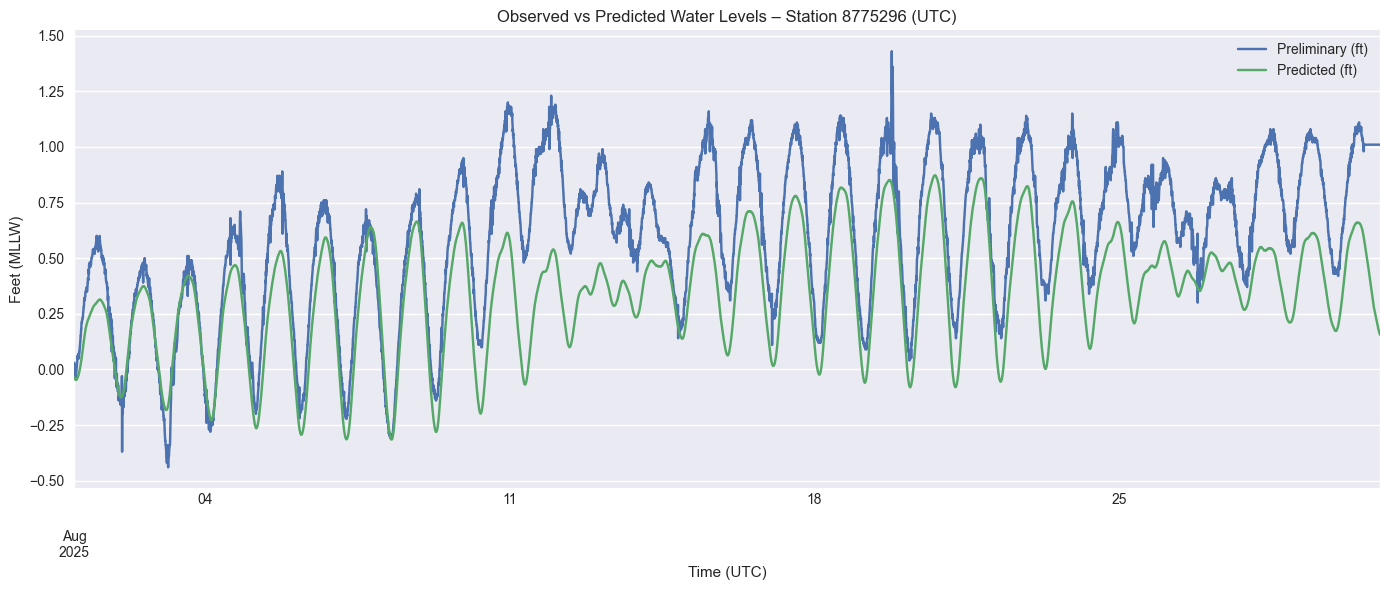

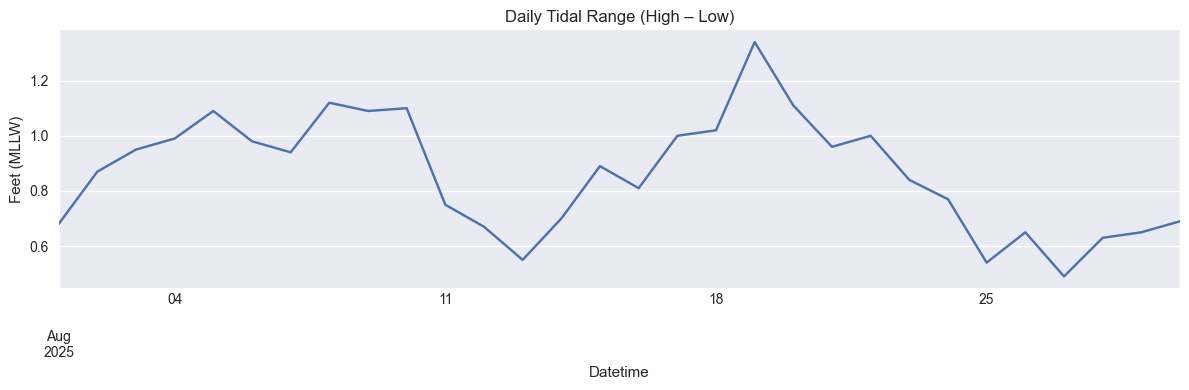

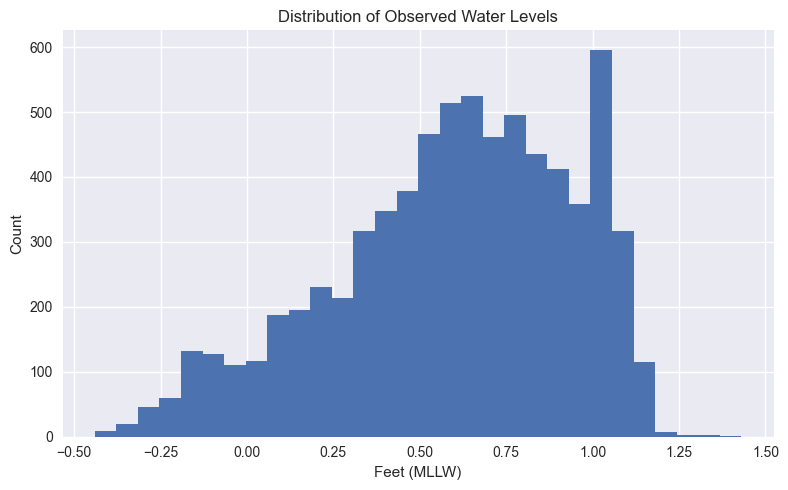

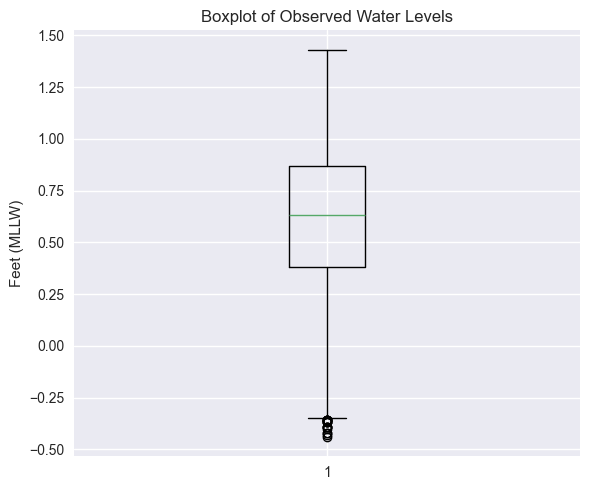

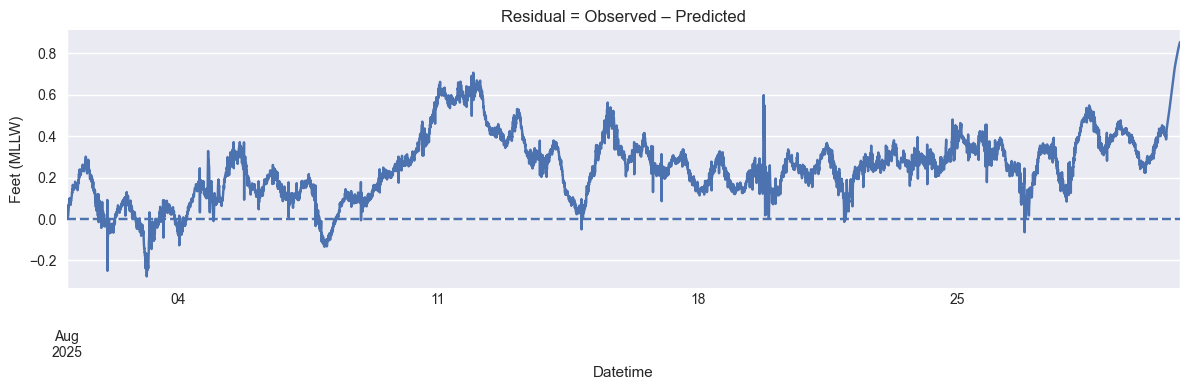

In [22]:
os.makedirs("../outputs", exist_ok=True)

# a) 1-month series
ax = df[["Preliminary (ft)", "Predicted (ft)"]].plot(figsize=(14,6),
    title="Observed vs Predicted Water Levels – Station 8775296 (UTC)")
ax.set_xlabel("Time (UTC)"); ax.set_ylabel("Feet (MLLW)")
ax.grid(True)
plt.tight_layout(); plt.savefig("../outputs/series_month.png", dpi=160)
plt.show()

# b) Daily tidal range
plt.figure(figsize=(12,4))
daily_range["Daily Range (ft)"].plot()
plt.title("Daily Tidal Range (High – Low)"); plt.ylabel("Feet (MLLW)")
plt.tight_layout(); plt.savefig("../outputs/daily_range.png", dpi=160)
plt.show()

# c) Histogram
plt.figure(figsize=(8,5))
df["Preliminary (ft)"].plot(kind="hist", bins=30)
plt.title("Distribution of Observed Water Levels")
plt.xlabel("Feet (MLLW)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("../outputs/hist_obs.png", dpi=160)
plt.show()

# d) Boxplot
plt.figure(figsize=(6,5))
plt.boxplot(df["Preliminary (ft)"].dropna(), vert=True)
plt.title("Boxplot of Observed Water Levels")
plt.ylabel("Feet (MLLW)")
plt.tight_layout(); plt.savefig("../outputs/boxplot_obs.png", dpi=160)
plt.show()

# e) Residual (Observed–Predicted)
if "Predicted (ft)" in df.columns:
    df["Residual (ft)"] = df["Preliminary (ft)"] - df["Predicted (ft)"]
    plt.figure(figsize=(12,4))
    df["Residual (ft)"].plot()
    plt.axhline(0, ls="--")
    plt.title("Residual = Observed – Predicted")
    plt.ylabel("Feet (MLLW)")
    plt.tight_layout(); plt.savefig("../outputs/residual.png", dpi=160)
    plt.show()

In [23]:
os.makedirs("../outputs", exist_ok=True)

df.to_csv("../outputs/cleaned_8775296_6min.csv")         # cleaned 6-min
df_hourly.to_csv("../outputs/cleaned_8775296_hourly.csv")
daily_summary.to_csv("../outputs/daily_summary.csv")
daily_range.to_csv("../outputs/daily_range.csv")

In [24]:
desc = df["Preliminary (ft)"].describe()
avg = float(desc["mean"]); p25 = float(desc["25%"]); p75 = float(desc["75%"])
rng_mean = float(daily_range["Daily Range (ft)"].mean())
rng_min  = float(daily_range["Daily Range (ft)"].min())
rng_max  = float(daily_range["Daily Range (ft)"].max())
avg, p25, p75, rng_mean, rng_min, rng_max

(0.596075, 0.38, 0.87, 0.8623333333333332, 0.49, 1.3399999999999999)

In [31]:
print("""
## ✅ Conclusions
- Data cleaned successfully: timestamps parsed, NaN handled, small gaps interpolated.
- Clear semidiurnal tide cycle (~12.4 hrs) is visible.
- Average observed water level ~ 0.596 ft (IQR ~ 0.38 - 0.87 ft).
- Daily tidal range averages ~ 0.86 ft (0.49 - 1.34 ft).
- Residuals show occasional surges likely due to atmospheric pressure/wind.
""")


## ✅ Conclusions
- Data cleaned successfully: timestamps parsed, NaN handled, small gaps interpolated.
- Clear semidiurnal tide cycle (~12.4 hrs) is visible.
- Average observed water level ~ 0.596 ft (IQR ~ 0.38 - 0.87 ft).
- Daily tidal range averages ~ 0.86 ft (0.49 - 1.34 ft).
- Residuals show occasional surges likely due to atmospheric pressure/wind.

